## side load ground truth comparisions

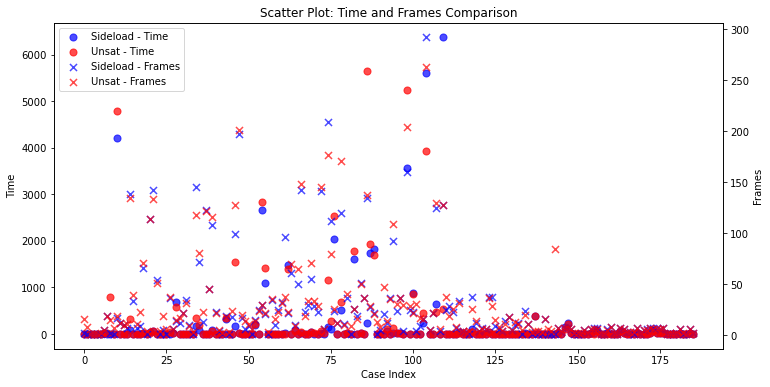

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Custom separator to handle irregular whitespace
sep = r'\s*\|\s*'

# Load data from the two files into DataFrames
sideload_df = pd.read_csv("hwmcc20-sideload.txt", sep=sep, header=None, names=["case_name", "time", "result"], engine='python')
unsat_df = pd.read_csv("hwmcc20-unsat.txt", sep=sep, header=None, names=["case_name", "time", "result"], engine='python')

# Remove any leading/trailing whitespaces from the columns
sideload_df = sideload_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
unsat_df = unsat_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Split the "result" column into separate columns
sideload_df[["result", "clauses", "frames"]] = sideload_df["result"].str.split(" ", expand=True)
unsat_df[["result", "clauses", "frames"]] = unsat_df["result"].str.split(" ", expand=True)

# Convert the "clauses" and "frames" columns to numeric data types
sideload_df[["clauses", "frames"]] = sideload_df[["clauses", "frames"]].apply(pd.to_numeric)
unsat_df[["clauses", "frames"]] = unsat_df[["clauses", "frames"]].apply(pd.to_numeric)

# Create a scatter plot with two y-axes for time and frames
fig, ax1 = plt.subplots(figsize=(12, 6))

# Get the case indices
case_indices = range(len(sideload_df))

# Plot the scatter points for time (both DataFrames)
ax1.scatter(case_indices, sideload_df['time'], color='blue', marker='o', alpha=0.7, s=50, label='Sideload - Time')
ax1.scatter(case_indices, unsat_df['time'], color='red', marker='o', alpha=0.7, s=50, label='Unsat - Time')

# Set labels and title for the first y-axis (time)
ax1.set_xlabel('Case Index')
ax1.set_ylabel('Time')
ax1.set_title('Scatter Plot: Time and Frames Comparison')

# Create a second y-axis for frames
ax2 = ax1.twinx()

# Plot the scatter points for frames (both DataFrames)
ax2.scatter(case_indices, sideload_df['frames'], color='blue', marker='x', alpha=0.7, s=50, label='Sideload - Frames')
ax2.scatter(case_indices, unsat_df['frames'], color='red', marker='x', alpha=0.7, s=50, label='Unsat - Frames')

# Set labels for the second y-axis (frames)
ax2.set_ylabel('Frames')

# Combine legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Display the plot
plt.show()

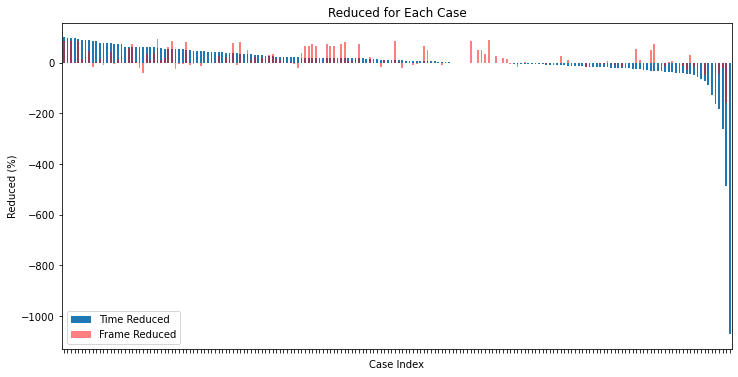

In [56]:
# Merge the two DataFrames on the "case_name" column
merged_df = sideload_df.merge(unsat_df, on="case_name", suffixes=("_sideload", "_unsat"))

# Calculate the percentage of improvement in time
merged_df['time_reduced'] = (merged_df['time_unsat'] - merged_df['time_sideload']) / merged_df['time_unsat'] * 100
merged_df['frame_reduced'] = (merged_df['frames_unsat'] - merged_df['frames_sideload']) / merged_df['frames_unsat'] * 100
# replace all value in 'case_name' to x.split('/')[-1]
merged_df['case_name'] = merged_df['case_name'].apply(lambda x: x.split('/')[-1])
# Set the index of the DataFrame to be the case_name
#merged_df.set_index('case_name', inplace=True)

# Sort the DataFrame by time improvement
sorted_df = merged_df.sort_values(by='time_reduced', ascending=False)


# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
sorted_df['time_reduced'].plot(kind='bar', ax=ax, label='Time Reduced')
sorted_df['frame_reduced'].plot(kind='bar', ax=ax, color='red', alpha=0.5, label='Frame Reduced')

# Set labels and title
ax.set_xlabel('Case Index')
ax.set_ylabel('Reduced (%)')
ax.set_title('Reduced for Each Case')

ax.set_xticklabels([])

# Add a legend
ax.legend()

# Display the plot
plt.show()


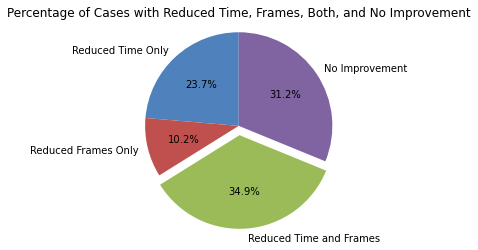

In [57]:
# Calculate the percentage of cases with reduced time and frames
merged_df["time_reduced_case"] = merged_df["time_sideload"] < merged_df["time_unsat"]
merged_df["frame_reduced_case"] = merged_df["frames_sideload"] < merged_df["frames_unsat"]
merged_df["both_reduced_case"] = merged_df["time_reduced_case"] & merged_df["frame_reduced_case"]

time_reduced_only_percentage = (merged_df["time_reduced_case"] & ~merged_df["frame_reduced_case"]).sum() / len(merged_df) * 100
frames_reduced_only_percentage = (merged_df["frame_reduced_case"] & ~merged_df["time_reduced_case"]).sum() / len(merged_df) * 100
both_reduced_percentage = merged_df["both_reduced_case"].sum() / len(merged_df) * 100
no_improvement_percentage = 100 - (time_reduced_only_percentage + frames_reduced_only_percentage + both_reduced_percentage)

# Pie chart data
sizes = [time_reduced_only_percentage, frames_reduced_only_percentage, both_reduced_percentage, no_improvement_percentage]
labels = ['Reduced Time Only', 'Reduced Frames Only', 'Reduced Time and Frames', 'No Improvement']
colors = ['#4F81BD', '#C0504D', '#9BBB59', '#8064A2']
explode = (0, 0, 0.1, 0)

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that the pie chart is circular
ax.axis('equal')

# Set the title
ax.set_title('Percentage of Cases with Reduced Time, Frames, Both, and No Improvement')

# Display the pie chart
plt.show()


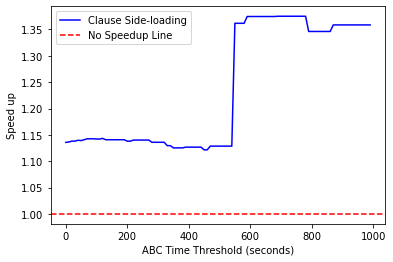

In [58]:
import numpy as np

def calculate_speedup_factor(df, x):
    # Filter cases where IC3ref Time is greater than x seconds
    #df_filtered = df[ (df["ABC Time"] > x) & (df["ABC Time"] < 10000) ]
    #df_filtered = df[ df["time_unsat"]> x ]
    #df_filtered = df[ df["time_sideload"]> x ]
    df_filtered = df[ (df["time_unsat"]> x) & (df["time_unsat"] < 30000) ]
    # Calculate the accumulated time for IC3ref and NN-IC3
    accumulated_ic3_time = df_filtered["time_unsat"].sum()
    accumulated_nn_ic3_time = df_filtered["time_sideload"].sum()

    # Calculate the speedup factor for the accumulated times
    speedup_factor = accumulated_ic3_time / accumulated_nn_ic3_time

    return speedup_factor

# Define the range of x values (thresholds)
#x_values = np.arange(0, 230, 10)
x_values = np.arange(0, 1000, 10)
#x_values = np.arange(0, 50000, 10)

# Calculate the speedup factor for each x value
speedup_factors = [calculate_speedup_factor(merged_df, x) for x in x_values]

# Create the plot
plt.plot(x_values, speedup_factors, color="blue", label="Clause Side-loading")
plt.xlabel("ABC Time Threshold (seconds)")
plt.ylabel("Speed up")
#plt.title("Speedup Factor by ABC Time Threshold")
plt.axhline(y=1, color="red", linestyle="--", label="No Speedup Line")
plt.legend()
plt.show()


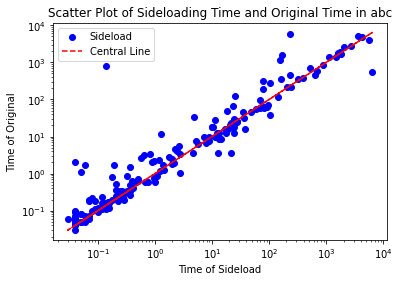

In [59]:
# Extract the columns needed for the scatter plot
#sideload_clauses = sideload_df["clauses"]
sideload_time = sideload_df["time"]
#unsat_clauses = unsat_df["clauses"]
unsat_time = unsat_df["time"]


# Create a scatter plot
plt.scatter(sideload_time, unsat_time, color="blue", label="Sideload")
#plt.scatter(unsat_clauses, unsat_time, color="red", label="Unsat")

# Set labels and title
plt.xlabel("Time of Sideload")
plt.ylabel("Time of Original")
plt.title("Scatter Plot of Sideloading Time and Original Time in abc")
# Add a central line
plt.plot(sideload_time, sideload_time, color="red", linestyle="--", label="Central Line")
plt.legend()
# Set logarithmic scale for both axes
plt.xscale("log")
plt.yscale("log")

# Display the plot
plt.show()

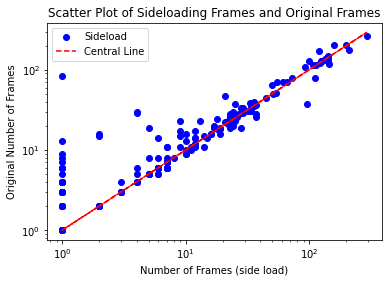

In [60]:
# Extract the columns needed for the scatter plot
#sideload_time = sideload_df["time"]
sideload_frames = sideload_df["frames"]
#unsat_time = unsat_df["time"]
unsat_frames = unsat_df["frames"]

# Create a scatter plot
plt.scatter(sideload_frames, unsat_frames, color="blue", label="Sideload")
#plt.scatter(unsat_frames, unsat_time, color="red", label="Unsat")

# Set labels and title
plt.xlabel("Number of Frames (side load)")
plt.ylabel("Original Number of Frames")
plt.title("Scatter Plot of Sideloading Frames and Original Frames")
# Add a central line
plt.plot(sideload_frames, sideload_frames, color="red", linestyle="--", label="Central Line")
plt.legend()
# Set logarithmic scale for both axes
plt.xscale("log")
plt.yscale("log")

# Display the plot
plt.show()

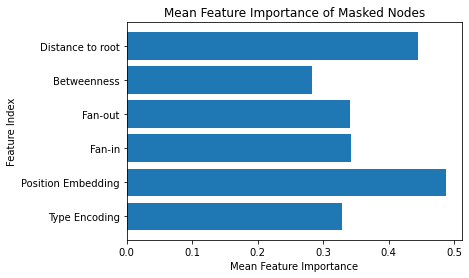

In [61]:
import numpy as np
import matplotlib.pyplot as plt

mean_feature_importance = np.array([0.374947, 0.32296842, 0.2627906, 0.28132135, 0.27235824, 0.41079497,
 0.27747044, 0.38448298, 0.37764075, 0.47072393, 0.5038246, 0.37386093,
 0.2848059, 0.36956352, 0.45604974, 0.26912755, 0.32067987, 0.39013413,
 0.2701648, 0.28285956, 0.3794835, 0.5099708])

# Combine and calculate the mean of feature importances for each group of features with the same name
mean_type_encoding = np.mean(mean_feature_importance[:9])
#mean_value_encoding = np.mean(mean_feature_importance[2:9])
mean_position_embedding = np.mean(mean_feature_importance[[9, 10]])
mean_fan_in = np.mean(mean_feature_importance[11:14])
mean_fan_out = np.mean(mean_feature_importance[14:19])
mean_distance_to_root = np.mean(mean_feature_importance[-2:])

# Create a new array with the combined feature importances
combined_mean_feature_importance = np.array([mean_type_encoding, mean_position_embedding,
                                            mean_fan_in, mean_fan_out, mean_feature_importance[-3],
                                            mean_distance_to_root])

# Generate the y values (indices) for the horizontal bar chart
y = np.arange(len(combined_mean_feature_importance))

# Plot the horizontal bar chart
plt.barh(y, combined_mean_feature_importance)

# Set custom y-axis labels
feature_labels = [
    "Type Encoding",
    "Position Embedding",
    "Fan-in",
    "Fan-out",
    "Betweenness",
    "Distance to root",
]

# Set y-axis tick labels
plt.yticks(y, feature_labels)

# Set x-axis and y-axis labels
plt.xlabel("Mean Feature Importance")
plt.ylabel("Feature Index")

# Set the title
plt.title("Mean Feature Importance of Masked Nodes")

# Show the plot
plt.show()


common cases: {'qspiflash_dualflexpress_divfive-p097', 'qspiflash_dualflexpress_divthree-p075', 'qspiflash_dualflexpress_divfive-p037', 'qspiflash_dualflexpress_divfive-p058'}
Mean size for each simplification level:
no_simplification: 1128.1764802631578
naive: 331.25
slight: 566.2194078947368
moderate: 566.1815789473684
deep: 371.2267361111111
thorough: 320.7986111111111


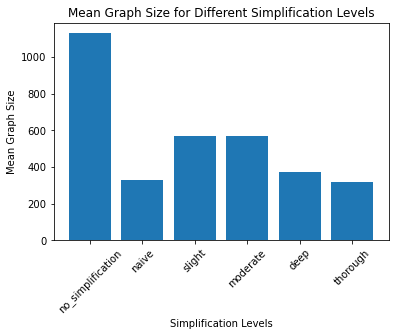

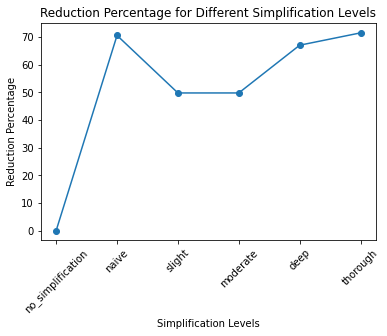

In [62]:
import os
import json
import matplotlib.pyplot as plt

def find_cases(directory):
    cases = set()
    sub_directory = os.path.join(directory, "bad_cube_cex2graph", "expr_to_build_graph")
    for case_name in os.listdir(sub_directory):
        case_path = os.path.join(sub_directory, case_name)
        if os.path.isdir(case_path):
            cases.add(case_name)
    return cases

def average_graph_length(directory, case_name):
    json_dir = os.path.join(directory, "bad_cube_cex2graph", "expr_to_build_graph", case_name)
    json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]
    total_length = 0
    count = 0

    for json_file in json_files:
        with open(os.path.join(json_dir, json_file), 'r') as f:
            graph = json.loads(f.read())
            total_length += len(graph)
            count += 1

    return total_length / count if count > 0 else 0

base_directory = "/data/guangyuh/coding_env/AIG2INV/AIG2INV_main/dataset_hwmcc2020_all_only_unsat_abc_"
simplification_levels = ["no_simplification", "naive", "slight", "moderate", "deep", "thorough"]

# Find common cases
cases = [find_cases(base_directory + level + "_10") for level in simplification_levels]
common_cases = set.intersection(*cases)
print("common cases:", common_cases)

# Calculate the average graph size for each simplification level
results = {}
for level in simplification_levels:
    directory = base_directory + level + "_10"
    avg_sizes = [average_graph_length(directory, case) for case in common_cases]
    results[level] = sum(avg_sizes) / len(avg_sizes)

print("Mean size for each simplification level:")
for level, avg_size in results.items():
    print(f"{level}: {avg_size}")
    
'''
bar chart
'''

# Assuming 'results' dictionary from the previous code snippet
simplification_levels = list(results.keys())
avg_sizes = list(results.values())

# Create a bar chart
plt.bar(simplification_levels, avg_sizes)
plt.xlabel("Simplification Levels")
plt.ylabel("Mean Graph Size")
plt.title("Mean Graph Size for Different Simplification Levels")
plt.xticks(rotation=45)

# Display the chart
plt.show()

'''
Line chart
'''
# Calculate reduction percentages
no_simplification_size = results['no_simplification']
reduction_percentages = [(no_simplification_size-size) / no_simplification_size * 100 for size in avg_sizes]

# Create a line chart with markers
plt.plot(simplification_levels, reduction_percentages, marker='o')
plt.xlabel("Simplification Levels")
plt.ylabel("Reduction Percentage")
plt.title("Reduction Percentage for Different Simplification Levels")
plt.xticks(rotation=45)

# Display the chart
plt.show()

In [63]:
import os
import pandas as pd

# Define the path to the directory
path = '/data/guangyuh/coding_env/AIG2INV/AIG2INV_main/case4comp/dataset_hwmcc2020_all_only_unsat_abc_no_simplification_0-38_comp'

# Create an empty dataframe to store the data
df = pd.DataFrame(columns=['M', 'Name'])

# Loop through each directory in the path
for dirpath, dirnames, filenames in os.walk(path):
    # Loop through each file in the directory
    for filename in filenames:
        # Check if the file has the .aag extension
        if filename.endswith('.aag'):
            # Construct the full path to the file
            filepath = os.path.join(dirpath, filename)
            # Read the first line of the file and store it in the dataframe
            with open(filepath, 'r') as f:
                first_line = f.readline().strip()
                df = pd.concat([df, pd.DataFrame({'Name': [filename.split('.aag')[0]], 'M': [first_line.split()[1]], 'I': [first_line.split()[2]], 'L': [first_line.split()[3]], 'O': [first_line.split()[4]], 'A': [first_line.split()[5]]})], ignore_index=True)
                
print("Number of files:", len(df))
# calculate the number of M - average, max, min
print("Average M:", df['M'].astype(int).mean(), "Max M:", df['M'].astype(int).max(), "Min M:", df['M'].astype(int).min())
# calculate the number of I + L - average, max, min
print("Average I + L:", (df['I'].astype(int) + df['L'].astype(int)).mean(), "Max I + L:", (df['I'].astype(int) + df['L'].astype(int)).max(), "Min I + L:", (df['I'].astype(int) + df['L'].astype(int)).min())
print("Average I:", df['I'].astype(int).mean(), "Max I:", df['I'].astype(int).max(), "Min I:", df['I'].astype(int).min())
print("Average L:", df['L'].astype(int).mean(), "Max L:", df['L'].astype(int).max(), "Min L:", df['L'].astype(int).min())
print("Average A:", df['A'].astype(int).mean(), "Max A:", df['A'].astype(int).max(), "Min A:", df['A'].astype(int).min())

Number of files: 195
Average M: 12430.210256410257 Max M: 97389 Min M: 209
Average I + L: 1501.8051282051283 Max I + L: 5764 Min I + L: 17
Average I: 965.4923076923077 Max I: 2925 Min I: 1
Average L: 536.3128205128205 Max L: 5002 Min L: 16
Average A: 10928.405128205128 Max A: 94445 Min A: 136
